In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Cargar los datos
data = pd.read_excel('exports/ts_final.xlsx')
data['fecha'] = pd.to_datetime(data['ANO'].astype(str) + '-' + data['MES'].astype(str) + '-01')
data.set_index('fecha', inplace=True)
ts = data['ventas_electrico']

print("Análisis inicial de la serie temporal:")
print(f"Período: {ts.index[0]} a {ts.index[-1]}")
print(f"Número de observaciones: {len(ts)}")
print(f"Valores nulos: {ts.isnull().sum()}")
print(f"Estadísticas descriptivas:")
print(ts.describe())


Análisis inicial de la serie temporal:
Período: 2015-01-01 00:00:00 a 2023-12-01 00:00:00
Número de observaciones: 108
Valores nulos: 0
Estadísticas descriptivas:
count     108.000000
mean     1604.972222
std      1538.109195
min        51.000000
25%       432.500000
50%      1019.500000
75%      2236.250000
max      6582.000000
Name: ventas_electrico, dtype: float64


In [3]:
# Dividir en entrenamiento (hasta 2022) y prueba (2023)
train = ts[:'2022-12-01']
test = ts['2023-01-01':]

print(f"\nDatos de entrenamiento: {len(train)} observaciones")
print(f"Datos de prueba: {len(test)} observaciones")


Datos de entrenamiento: 96 observaciones
Datos de prueba: 12 observaciones


In [42]:
# Análisis de estacionariedad más detallado
def check_stationarity(timeseries, title):
    print(f'\n=== Análisis de Estacionariedad: {title} ===')
    
    # Prueba ADF
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Valores críticos:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("Serie es estacionaria")
        return True
    else:
        print("Serie NO es estacionaria")
        return False

# Verificar estacionariedad de la serie original
is_stationary = check_stationarity(train, "Serie Original")


=== Análisis de Estacionariedad: Serie Original ===
ADF Statistic: 0.755088
p-value: 0.990876
Valores críticos:
	1%: -3.510
	5%: -2.896
	10%: -2.585
Serie NO es estacionaria


In [44]:
# Aplicar transformaciones si es necesario
if not is_stationary:
    # Probar diferenciación simple
    train_diff1 = train.diff().dropna()
    is_stationary_diff1 = check_stationarity(train_diff1, "Primera Diferencia")
    
    if not is_stationary_diff1:
        # Probar diferenciación estacional
        train_diff12 = train.diff(12).dropna()
        is_stationary_diff12 = check_stationarity(train_diff12, "Diferencia Estacional")
        
        # Probar diferenciación combinada
        train_diff_combined = train.diff().diff(12).dropna()
        is_stationary_combined = check_stationarity(train_diff_combined, "Diferencia Combinada")



=== Análisis de Estacionariedad: Primera Diferencia ===
ADF Statistic: -5.689472
p-value: 0.000001
Valores críticos:
	1%: -3.508
	5%: -2.895
	10%: -2.585
Serie es estacionaria


In [46]:
# Función para búsqueda automática de parámetros SARIMA
def auto_sarima_search(train_data, max_p=3, max_d=2, max_q=3, max_P=2, max_D=1, max_Q=2, s=12):
    """
    Búsqueda automática de los mejores parámetros SARIMA basada en AIC
    """
    print("\n=== Búsqueda Automática de Parámetros SARIMA ===")
    
    best_aic = float('inf')
    best_params = None
    best_seasonal_params = None
    results = []
    
    # Definir rangos de parámetros
    p_range = range(0, max_p + 1)
    d_range = range(0, max_d + 1)
    q_range = range(0, max_q + 1)
    P_range = range(0, max_P + 1)
    D_range = range(0, max_D + 1)
    Q_range = range(0, max_Q + 1)
    
    total_combinations = len(p_range) * len(d_range) * len(q_range) * len(P_range) * len(D_range) * len(Q_range)
    print(f"Probando {total_combinations} combinaciones de parámetros...")
    
    count = 0
    for p, d, q in product(p_range, d_range, q_range):
        for P, D, Q in product(P_range, D_range, Q_range):
            try:
                count += 1
                if count % 50 == 0:
                    print(f"Progreso: {count}/{total_combinations}")
                
                model = SARIMAX(train_data, 
                               order=(p, d, q), 
                               seasonal_order=(P, D, Q, s))
                fitted_model = model.fit(disp=False)
                
                aic = fitted_model.aic
                results.append({
                    'params': (p, d, q),
                    'seasonal_params': (P, D, Q, s),
                    'aic': aic,
                    'bic': fitted_model.bic
                })
                
                if aic < best_aic:
                    best_aic = aic
                    best_params = (p, d, q)
                    best_seasonal_params = (P, D, Q, s)
                    
            except:
                continue
    
    # Mostrar los 5 mejores modelos
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('aic').head(10)
    
    print("\n=== Top 10 Mejores Modelos (por AIC) ===")
    for i, row in results_df.iterrows():
        print(f"SARIMA{row['params']}{row['seasonal_params']}: AIC={row['aic']:.2f}, BIC={row['bic']:.2f}")
    
    return best_params, best_seasonal_params, results_df


In [48]:
# Realizar búsqueda automática
best_order, best_seasonal_order, model_results = auto_sarima_search(train)

print(f"\n=== Mejor Modelo Encontrado ===")
print(f"SARIMA{best_order}{best_seasonal_order}")
print(f"AIC: {model_results.iloc[0]['aic']:.2f}")


=== Búsqueda Automática de Parámetros SARIMA ===
Probando 864 combinaciones de parámetros...
Progreso: 50/864
Progreso: 100/864
Progreso: 150/864
Progreso: 200/864
Progreso: 250/864
Progreso: 300/864
Progreso: 350/864
Progreso: 400/864
Progreso: 450/864
Progreso: 500/864
Progreso: 550/864
Progreso: 600/864
Progreso: 650/864
Progreso: 700/864
Progreso: 750/864
Progreso: 800/864
Progreso: 850/864

=== Top 10 Mejores Modelos (por AIC) ===
SARIMA(1, 2, 3)(2, 1, 0, 12): AIC=1282.41, BIC=1299.25
SARIMA(0, 2, 3)(2, 1, 0, 12): AIC=1284.40, BIC=1298.84
SARIMA(1, 2, 3)(0, 1, 2, 12): AIC=1284.44, BIC=1301.29
SARIMA(0, 2, 2)(2, 1, 0, 12): AIC=1284.53, BIC=1296.56
SARIMA(1, 2, 2)(2, 1, 0, 12): AIC=1284.94, BIC=1299.38
SARIMA(0, 2, 2)(0, 1, 2, 12): AIC=1285.64, BIC=1297.67
SARIMA(1, 2, 3)(0, 1, 1, 12): AIC=1285.71, BIC=1300.15
SARIMA(1, 2, 3)(1, 1, 1, 12): AIC=1285.83, BIC=1302.67
SARIMA(0, 2, 3)(0, 1, 2, 12): AIC=1285.83, BIC=1300.27
SARIMA(1, 2, 2)(0, 1, 2, 12): AIC=1285.89, BIC=1300.33

=== Mejo

In [50]:
# Ajustar el mejor modelo
print("\n=== Ajustando Mejor Modelo ===")
best_model = SARIMAX(train, 
                     order=best_order, 
                     seasonal_order=best_seasonal_order)
best_model_fit = best_model.fit(disp=False)



=== Ajustando Mejor Modelo ===


In [52]:
# Mostrar resumen del modelo
print("\n=== Resumen del Modelo ===")
print(best_model_fit.summary())


=== Resumen del Modelo ===
                                      SARIMAX Results                                      
Dep. Variable:                    ventas_electrico   No. Observations:                   96
Model:             SARIMAX(1, 2, 3)x(2, 1, [], 12)   Log Likelihood                -634.203
Date:                             Thu, 10 Jul 2025   AIC                           1282.405
Time:                                     01:01:04   BIC                           1299.252
Sample:                                 01-01-2015   HQIC                          1289.169
                                      - 12-01-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7040      0.187     -3.766      0.000      -1.070      -0.338


=== Diagnóstico del Modelo ===


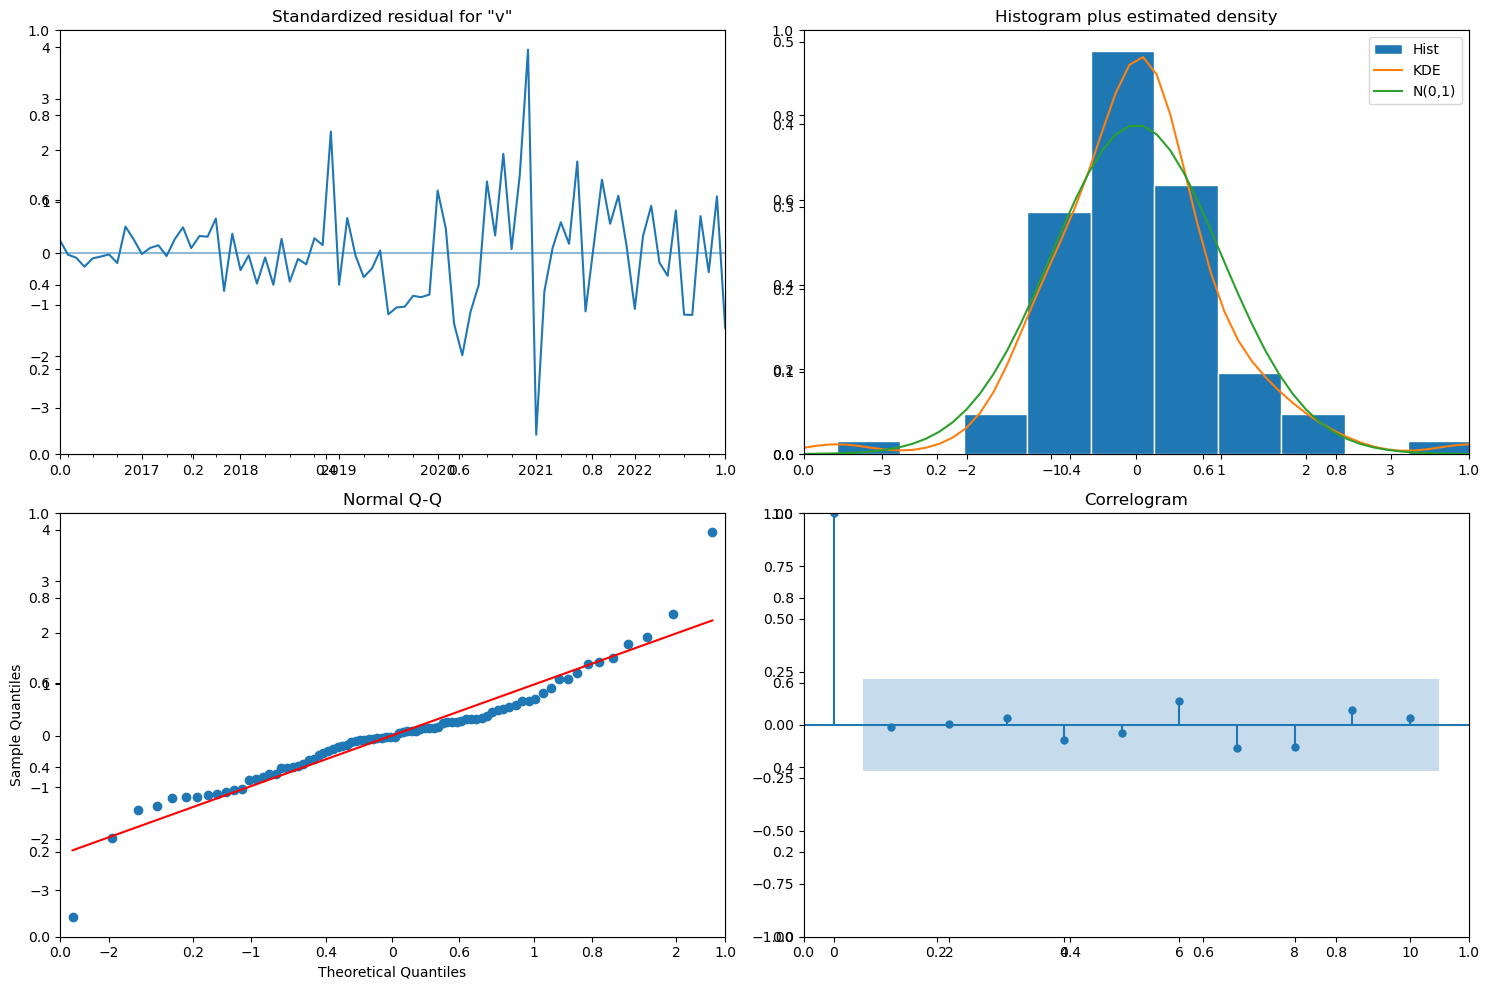

In [54]:
# Diagnóstico del modelo
print("\n=== Diagnóstico del Modelo ===")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
best_model_fit.plot_diagnostics(fig=fig)
plt.tight_layout()
plt.show()

In [56]:
# Realizar predicciones con el mejor modelo
pred_best = best_model_fit.get_forecast(steps=len(test))
pred_mean_best = pred_best.predicted_mean
pred_ci_best = pred_best.conf_int()

In [58]:
# Calcular métricas de evaluación
rmse_best = np.sqrt(mean_squared_error(test, pred_mean_best))
mape_best = mean_absolute_percentage_error(test, pred_mean_best)

print(f"\n=== Resultados del Mejor Modelo ===")
print(f'RMSE: {rmse_best:.2f}')
print(f'MAPE: {mape_best:.4f} ({mape_best*100:.2f}%)')


=== Resultados del Mejor Modelo ===
RMSE: 1582.26
MAPE: 0.2823 (28.23%)


In [60]:
# Modelo con ventana deslizante para mejorar adaptabilidad
def rolling_forecast(train_data, test_data, order, seasonal_order, window_size=None):
    """
    Predicción con ventana deslizante para mejorar la adaptabilidad
    """
    if window_size is None:
        window_size = len(train_data)
    
    predictions = []
    
    for i in range(len(test_data)):
        # Usar ventana deslizante
        if len(train_data) > window_size:
            train_window = train_data[-window_size:]
        else:
            train_window = train_data
        
        # Ajustar modelo
        model = SARIMAX(train_window, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        
        # Predecir siguiente punto
        pred = model_fit.forecast(steps=1)
        predictions.append(pred.iloc[0])
        
        # Actualizar datos de entrenamiento
        train_data = pd.concat([train_data, test_data.iloc[i:i+1]])
    
    return pd.Series(predictions, index=test_data.index)


In [62]:
# Aplicar predicción con ventana deslizante
print("\n=== Aplicando Predicción con Ventana Deslizante ===")
rolling_pred = rolling_forecast(train, test, best_order, best_seasonal_order, window_size=36)



=== Aplicando Predicción con Ventana Deslizante ===


In [64]:
# Métricas para predicción rolling
rmse_rolling = np.sqrt(mean_squared_error(test, rolling_pred))
mape_rolling = mean_absolute_percentage_error(test, rolling_pred)

print(f"RMSE (Rolling): {rmse_rolling:.2f}")
print(f"MAPE (Rolling): {mape_rolling:.4f} ({mape_rolling*100:.2f}%)")


RMSE (Rolling): 1100.87
MAPE (Rolling): 0.1854 (18.54%)


In [66]:
# Comparar modelos
comparison_df = pd.DataFrame({
    'Modelo': ['SARIMA Original', 'SARIMA Optimizado', 'SARIMA Rolling'],
    'RMSE': [1752.99, rmse_best, rmse_rolling],
    'MAPE': [0.3293, mape_best, mape_rolling]
})

print("\n=== Comparación de Modelos ===")
print(comparison_df.to_string(index=False))


=== Comparación de Modelos ===
           Modelo        RMSE     MAPE
  SARIMA Original 1752.990000 0.329300
SARIMA Optimizado 1582.256148 0.282295
   SARIMA Rolling 1100.869917 0.185405


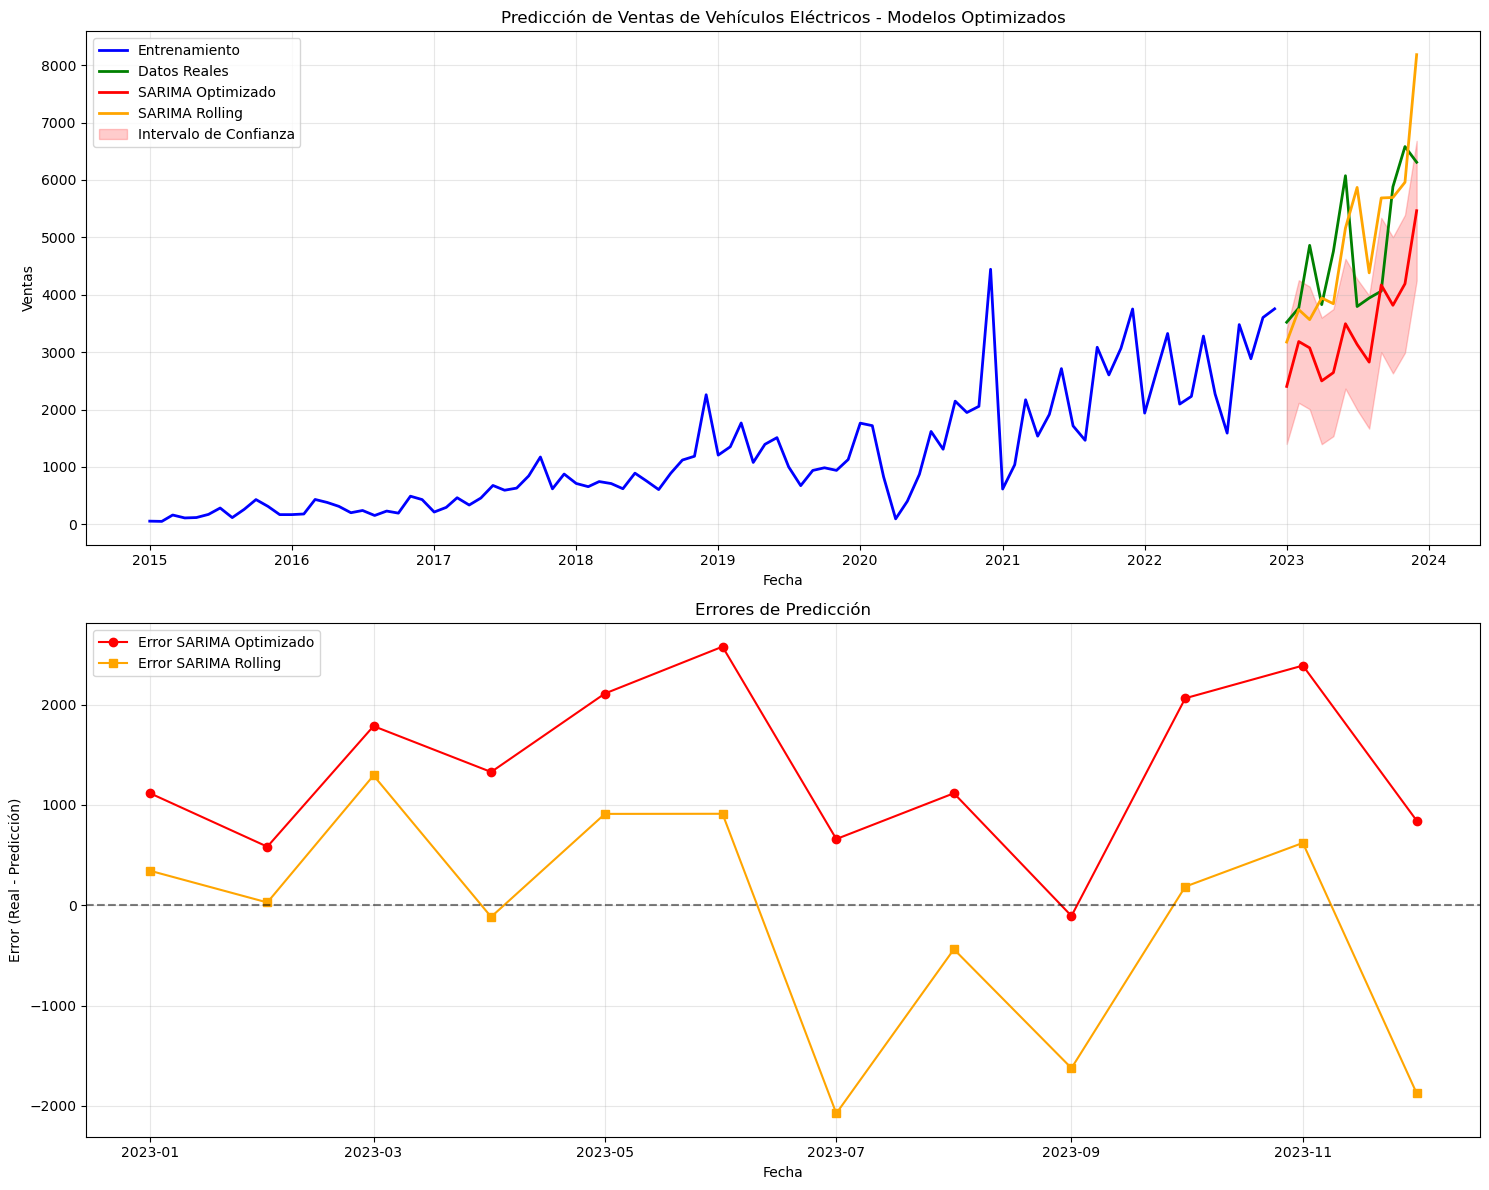

In [70]:
# Visualización mejorada
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Gráfico principal
ax1 = axes[0]
ax1.plot(train, label='Entrenamiento', color='blue', linewidth=2)
ax1.plot(test, label='Datos Reales', color='green', linewidth=2)
ax1.plot(pred_mean_best, label='SARIMA Optimizado', color='red', linewidth=2)
ax1.plot(rolling_pred, label='SARIMA Rolling', color='orange', linewidth=2)
ax1.fill_between(pred_ci_best.index, pred_ci_best.iloc[:, 0], pred_ci_best.iloc[:, 1], 
                color='red', alpha=0.2, label='Intervalo de Confianza')
ax1.set_title('Predicción de Ventas de Vehículos Eléctricos - Modelos Optimizados')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Ventas')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico de errores
ax2 = axes[1]
error_best = test - pred_mean_best
error_rolling = test - rolling_pred

ax2.plot(error_best, label='Error SARIMA Optimizado', color='red', marker='o')
ax2.plot(error_rolling, label='Error SARIMA Rolling', color='orange', marker='s')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_title('Errores de Predicción')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Error (Real - Predicción)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [72]:
# Predicciones futuras
print("\n=== Predicciones Futuras (2024) ===")
future_steps = 12
future_pred = best_model_fit.get_forecast(steps=len(test) + future_steps)
future_mean = future_pred.predicted_mean
future_ci = future_pred.conf_int()



=== Predicciones Futuras (2024) ===


In [74]:
# Mostrar predicciones para 2024
future_2024 = future_mean[len(test):]
print("Predicciones para 2024:")
for i, pred in enumerate(future_2024):
    month = i + 1
    print(f"2024-{month:02d}: {pred:.0f} ventas")


Predicciones para 2024:
2024-01: 2951 ventas
2024-02: 3591 ventas
2024-03: 4264 ventas
2024-04: 3449 ventas
2024-05: 3695 ventas
2024-06: 4612 ventas
2024-07: 3775 ventas
2024-08: 3372 ventas
2024-09: 5035 ventas
2024-10: 4558 ventas
2024-11: 5105 ventas
2024-12: 5755 ventas


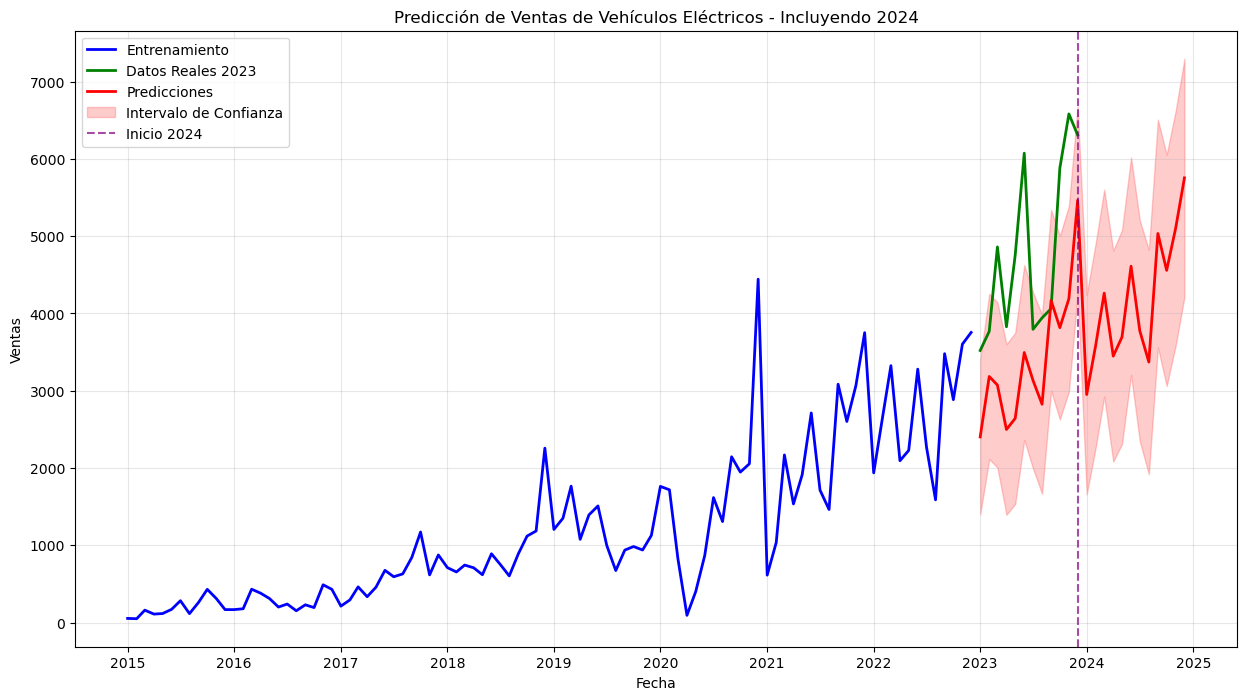

In [76]:
# Gráfico con predicciones futuras
plt.figure(figsize=(15, 8))
plt.plot(train.index, train, label='Entrenamiento', color='blue', linewidth=2)
plt.plot(test.index, test, label='Datos Reales 2023', color='green', linewidth=2)
plt.plot(future_mean.index, future_mean, label='Predicciones', color='red', linewidth=2)
plt.fill_between(future_ci.index, future_ci.iloc[:, 0], future_ci.iloc[:, 1], 
                color='red', alpha=0.2, label='Intervalo de Confianza')

# Marcar el punto de división entre predicciones 2023 y 2024
plt.axvline(x=test.index[-1], color='purple', linestyle='--', alpha=0.7, label='Inicio 2024')

plt.title('Predicción de Ventas de Vehículos Eléctricos - Incluyendo 2024')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [78]:
print("\n=== Análisis Completado ===")
print(f"Mejor modelo: SARIMA{best_order}{best_seasonal_order}")
print(f"Mejora en RMSE: {1752.99 - rmse_best:.2f}")
print(f"Mejora en MAPE: {(0.3293 - mape_best)*100:.2f} puntos porcentuales")


=== Análisis Completado ===
Mejor modelo: SARIMA(1, 2, 3)(2, 1, 0, 12)
Mejora en RMSE: 170.73
Mejora en MAPE: 4.70 puntos porcentuales


In [80]:
# Opción 2: Continuar con rolling para 2024
print("OPCIÓN 2: Continuar con enfoque rolling")
# Simular predicciones rolling para 2024 (sin datos reales)
future_dates = pd.date_range('2024-01-01', periods=12, freq='MS')
rolling_future_pred = []
rolling_future_ci = []

current_series = updated_series.copy()

for i in range(12):
    # Usar ventana deslizante
    if len(current_series) > 36:
        train_window = current_series[-36:]
    else:
        train_window = current_series
    
    try:
        model = SARIMAX(train_window, order=best_order, seasonal_order=best_seasonal_order)
        model_fit = model.fit(disp=False)
        pred = model_fit.get_forecast(steps=1)
        
        pred_value = pred.predicted_mean.iloc[0]
        rolling_future_pred.append(pred_value)
        rolling_future_ci.append([pred.conf_int().iloc[0, 0], pred.conf_int().iloc[0, 1]])
        
        # Actualizar serie con predicción (para siguiente iteración)
        new_point = pd.Series([pred_value], index=[future_dates[i]])
        current_series = pd.concat([current_series, new_point])
        
    except:
        # Fallback: usar tendencia reciente
        recent_growth = current_series.iloc[-3:].pct_change().mean()
        pred_value = current_series.iloc[-1] * (1 + recent_growth)
        rolling_future_pred.append(pred_value)
        rolling_future_ci.append([pred_value * 0.8, pred_value * 1.2])
        
        new_point = pd.Series([pred_value], index=[future_dates[i]])
        current_series = pd.concat([current_series, new_point])

rolling_future_series = pd.Series(rolling_future_pred, index=future_dates)
rolling_future_ci_df = pd.DataFrame(rolling_future_ci, index=future_dates, columns=['lower', 'upper'])


OPCIÓN 2: Continuar con enfoque rolling


NameError: name 'updated_series' is not defined

In [82]:
 Encontrar mejores parámetros
best_order, best_seasonal_order, best_aic = quick_sarima_search(train)
print(f"Mejor modelo encontrado: SARIMA{best_order}{best_seasonal_order}")
print(f"AIC: {best_aic:.2f}\n")


SyntaxError: invalid syntax (1309208273.py, line 1)